In [1]:

import numpy as np
import pandas as pd
import pickle
import networkx as nx 
import osmnx as ox 
import numpy as np 
import seaborn as sns 
import numpy as np
from scipy.spatial.distance import cdist
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point, LineString

In [2]:
#Load volume dataset
csv_pd=pd.read_excel("/Users/filipmoennilsen/Documents/Skolearbeid/BI_Master_BAN/4. Semester/Master_Thesis/Master_Python/TrafficVolume/data/weekly_data_xl.xlsx")

# Load graph
with open("/Users/filipmoennilsen/Documents/Skolearbeid/BI_Master_BAN/4. Semester/Master_Thesis/Master_Python/roadNetwork_Venv/data/BaseGraph_eRoad.pickle", 'rb') as file:
    H = pickle.load(file)

#H = pd.read_pickle("/Users/filipmoennilsen/Documents/Skolearbeid/BI_Master_BAN/4. Semester/Master_Thesis/Master_Python/roadNetwork_Venv/data/BaseGraph_eRoad.pickle")


/var/folders/67/gxr6c90j7x9_c9pz8lgvd8n40000gn/T/ipykernel_19106/994236420.py:6: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  H = pickle.load(file)


In [3]:
#Remove volume1 and volume2
csv_pd=csv_pd.drop("volume1", axis="columns")
csv_pd=csv_pd.drop("volume2", axis="columns")

In [4]:
csv_pd.head()

,Unnamed: 0,id,name,lat,lon,volume,year,month
0,0,41379V1201935,MESNADALSARMEN,61.115044,10.456279,13023,2018,1
1,2,41379V1201935,MESNADALSARMEN,61.115044,10.456279,13998,2018,2
2,4,41379V1201935,MESNADALSARMEN,61.115044,10.456279,13878,2018,3
3,6,41379V1201935,MESNADALSARMEN,61.115044,10.456279,14288,2018,4
4,8,41379V1201935,MESNADALSARMEN,61.115044,10.456279,14669,2018,5


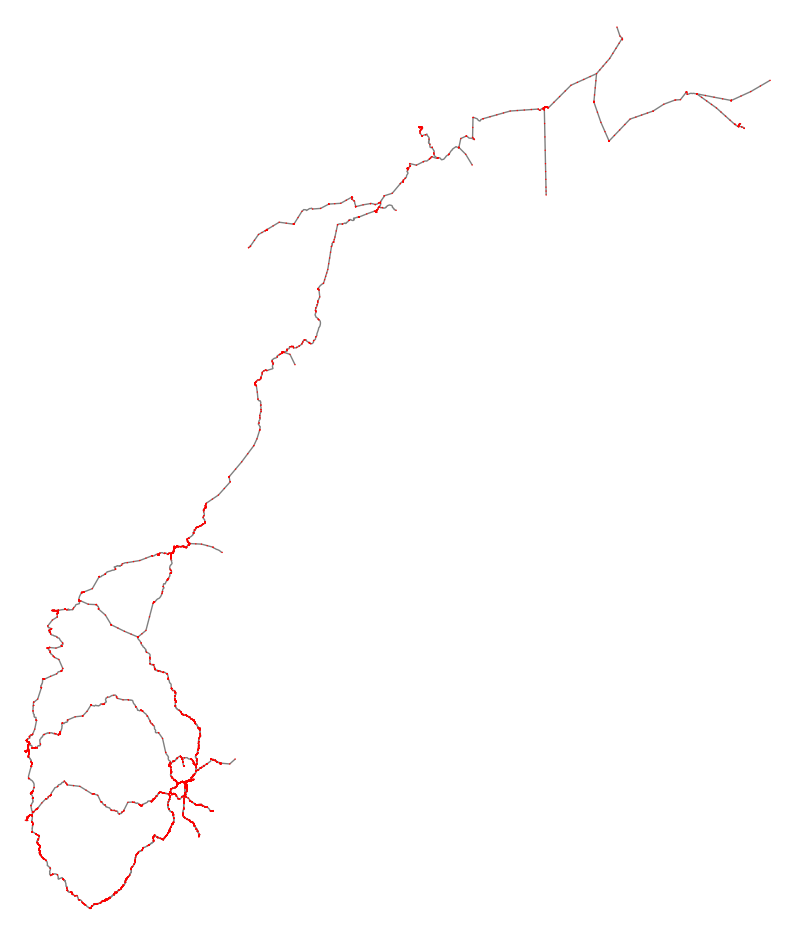

(<Figure size 1000x1500 with 1 Axes>, <AxesSubplot: >)

In [5]:
#Plot graph
ox.plot_graph(H, figsize = (10, 15), node_color="red", edge_color = "gray", bgcolor = "white", node_size=1, edge_linewidth = 1)

In [ ]:
print("Nodes:", list(H.nodes))
print("Edges:", list(H.edges))


In [ ]:
print("Adjacency List:")
for node in H.adj:
    print(node, H.adj[node])


In [13]:
# Retrieve absolute value of gradients

lengths = []
for i in H.edges:
    length = H.edges[i]['length']
    lengths.append(length)

grades = [abs(H.edges[i]['wa_grade']) for i in H.edges]  

KeyError: 'grades'

In [4]:
#Create grades and elevations from H.nodes
grades = [H.edges[i]['wa_grade'] for i in H.edges]
#elevations = [H.nodes[i]['elevation'] if float('-inf') < H.nodes[i]['elevation'] < float('inf') else 0 for i in H.nodes]
elevations = [H.nodes[i]['elevation'] if np.all(np.logical_and(float('-inf') < H.nodes[i]['elevation'], H.nodes[i]['elevation'] < float('inf'))) else 0 for i in H.nodes]


In [14]:
#list(H.nodes(data=True))[0:5]
list(H.edges(data=True))[0:5]

[(155191,
  155273,
  {'id': 138086,
   'oneway': False,
   'ref': 'Kjonerudvegen',
   'name': 'Kjonerudvegen',
   'funcroadclass': 0,
   'roadclass': '0',
   'isFerry': 0,
   'isBridge': 0,
   'isTunnel': 0,
   'speedlim': 60,
   'drivetime': 0.017584889317411152,
   'length': 15.291208102096657,
   'length_weight': 15.291208102096657,
   'u': 155191,
   'v': 155273,
   'grade': -0.03,
   'grade_abs': 0.03}),
 (155191,
  351348,
  {'id': [363590, 2168667, 362740, 138014],
   'oneway': False,
   'ref': 'E6',
   'name': 'E6',
   'funcroadclass': 0,
   'roadclass': '0',
   'isFerry': 0,
   'isBridge': 0,
   'isTunnel': 0,
   'speedlim': 110,
   'drivetime': [0.19838599168327925,
    0.08097851727109437,
    0.022208227484511525,
    0.003121153025136814],
   'length': 485.74388175423786,
   'length_weight': [129.09618695391856,
    35.40442062748214,
    4.975751199493471,
    316.2675229733437],
   'u': [155192, 351173, 351174, 155191],
   'v': [155192, 351348, 351173, 351174],
   'grad

In [15]:
labels={n[1]:n[0] for n in enumerate(H.nodes)}

H=nx.relabel_nodes(H, labels)

*#Trying to add month attribute to H object*


In [ ]:
import numpy as np
from scipy.spatial.distance import cdist
import geopandas as gpd
import networkx as nx

# create road nodes array with latitude and longitude information
road_nodes = np.array([(node, data['geometry'].coords[0][0], data['geometry'].coords[0][1])
                      for node, data in H.nodes(data=True)])

# iterate over each row in the volume dataframe and assign volume to edges in the graph
for i, row in csv_pd.iterrows():
    # get the closest road node to the volume point
    point = row[['lon', 'lat']].values.reshape(1, -1)
    dist_matrix = cdist(point, road_nodes[:, 1:], metric='euclidean')
    min_index = np.argmin(dist_matrix)
    node_id = road_nodes[min_index, 0]
    
    # assign volume to each edge in the graph that contains the closest road node
    edges = H.edges(node_id, data=True)
    total_distance = sum([H[u][v]['length'] for (u, v) in [(e[0], e[1]) for e in edges]])
    for u, v, data in edges:
        edge_weight = data['length']
        month_volume = row['volume{}'.format(row['month'])]
        traffic_flow = month_volume * (edge_weight / total_distance)
        if 'traffic_flow' not in data:
            data['traffic_flow'] = traffic_flow
        else:
            data['traffic_flow'] += traffic_flow
        nx.set_edge_attributes(H, {(u,v): {'traffic_flow': data['traffic_flow']}})

In [6]:
# create road nodes array with latitude and longitude information
road_nodes = np.array([(node, data['geometry'].coords[0][0], data['geometry'].coords[0][1])
                      for node, data in H.nodes(data=True)])
road_nodes[0:10]

array([[1.55191000e+05, 1.11274658e+01, 6.07862046e+01],
       [1.55201000e+05, 1.11271850e+01, 6.07864285e+01],
       [1.55273000e+05, 1.11275347e+01, 6.07863343e+01],
       [1.55289000e+05, 1.11273998e+01, 6.07864158e+01],
       [1.55971000e+05, 1.19938295e+01, 6.01891885e+01],
       [1.56057000e+05, 1.20088291e+01, 6.01867450e+01],
       [1.56658000e+05, 1.19923784e+01, 6.01895326e+01],
       [1.56671000e+05, 1.19923863e+01, 6.01893538e+01],
       [1.56688000e+05, 1.19926999e+01, 6.01893296e+01],
       [1.56709000e+05, 1.19928378e+01, 6.01894703e+01]])

In [7]:
traffic_points = gpd.GeoDataFrame(csv_pd, geometry=gpd.points_from_xy(csv_pd['lon'], csv_pd['lat']))

In [8]:
traffic_points

,Unnamed: 0,id,name,lat,lon,volume,year,month,geometry
0,0,41379V1201935,MESNADALSARMEN,61.115044,10.456279,13023,2018,1,POINT (10.45628 61.11504)
1,2,41379V1201935,MESNADALSARMEN,61.115044,10.456279,13998,2018,2,POINT (10.45628 61.11504)
2,4,41379V1201935,MESNADALSARMEN,61.115044,10.456279,13878,2018,3,POINT (10.45628 61.11504)
3,6,41379V1201935,MESNADALSARMEN,61.115044,10.456279,14288,2018,4,POINT (10.45628 61.11504)
4,8,41379V1201935,MESNADALSARMEN,61.115044,10.456279,14669,2018,5,POINT (10.45628 61.11504)
...,...,...,...,...,...,...,...,...,...
7268,14472,22331V248904,Eksetstranda,62.159291,6.042887,9759,2018,8,POINT (6.04289 62.15929)
7269,14474,22331V248904,Eksetstranda,62.159291,6.042887,9677,2018,9,POINT (6.04289 62.15929)
7270,14476,22331V248904,Eksetstranda,62.159291,6.042887,9630,2018,10,POINT (6.04289 62.15929)
7271,14478,22331V248904,Eksetstranda,62.159291,6.042887,9645,2018,11,POINT (6.04289 62.15929)


In [9]:
def nearest_edge(point, road_nodes):
    point = (point.x, point.y)
    dist_matrix = cdist([point], road_nodes[:, 1:], metric='euclidean')
    min_index = np.argmin(dist_matrix)
    node_id = road_nodes[min_index, 0]
    edges = H.edges(node_id, data=True)
    edge_distances = [LineString([H.nodes[u]['geometry'].coords[0], H.nodes[v]['geometry'].coords[0]]).distance(Point(point)) for u, v, data in edges]
    nearest_edge = list(edges)[np.argmin(edge_distances)]
    return nearest_edge

In [ ]:
nearest_edge()

In [35]:
traffic_points['nearest_edge'] = traffic_points.geometry.apply(lambda x: nearest_edge(x, road_nodes))

In [10]:
traffic_points = traffic_points.drop_duplicates('id')
traffic_points

,Unnamed: 0,id,name,lat,lon,volume,year,month,geometry
0,0,41379V1201935,MESNADALSARMEN,61.115044,10.456279,13023,2018,1,POINT (10.45628 61.11504)
12,24,43294V181263,MEHEIA STASJON,59.629705,9.499576,4098,2018,1,POINT (9.49958 59.62971)
24,48,76082V578594,Svemarka,63.542709,10.862757,6651,2018,1,POINT (10.86276 63.54271)
36,72,21376V2607269,Ørje,59.484949,11.745634,4636,2018,1,POINT (11.74563 59.48495)
48,96,68771V2258479,KLINESTAD,59.164143,10.199460,25770,2018,1,POINT (10.19946 59.16414)
...,...,...,...,...,...,...,...,...,...
7213,14362,55982V384008,LJØSNE,61.049293,7.594630,1817,2018,1,POINT (7.59463 61.04929)
7225,14386,53385V249032,Elvadalen,62.143426,6.074885,8030,2018,1,POINT (6.07489 62.14343)
7237,14410,60900V248916,Molde fergekai øst,62.737082,7.178031,7437,2018,1,POINT (7.17803 62.73708)
7249,14434,45383V319532,Haukås,59.347443,5.453745,3741,2018,1,POINT (5.45374 59.34744)


In [41]:
traffic_points.head()

,Unnamed: 0,id,name,lat,lon,volume,year,month,geometry,nearest_edge
0,0,41379V1201935,MESNADALSARMEN,61.115044,10.456279,13023,2018,1,POINT (10.45628 61.11504),"(280.0, 279, {'id': [1186598, 1186606, 1186574..."
1,2,41379V1201935,MESNADALSARMEN,61.115044,10.456279,13998,2018,2,POINT (10.45628 61.11504),"(280.0, 279, {'id': [1186598, 1186606, 1186574..."
2,4,41379V1201935,MESNADALSARMEN,61.115044,10.456279,13878,2018,3,POINT (10.45628 61.11504),"(280.0, 279, {'id': [1186598, 1186606, 1186574..."
3,6,41379V1201935,MESNADALSARMEN,61.115044,10.456279,14288,2018,4,POINT (10.45628 61.11504),"(280.0, 279, {'id': [1186598, 1186606, 1186574..."
4,8,41379V1201935,MESNADALSARMEN,61.115044,10.456279,14669,2018,5,POINT (10.45628 61.11504),"(280.0, 279, {'id': [1186598, 1186606, 1186574..."


In [40]:
traffic_points['nearest_edge'][600]

(5862.0,
 4705,
 {'id': [1745496, 1745485, 1745495],
  'oneway': False,
  'ref': 'E6',
  'name': 'E6',
  'funcroadclass': 0,
  'roadclass': '0',
  'isFerry': 0,
  'isBridge': 0,
  'isTunnel': 0,
  'speedlim': 80,
  'drivetime': [0.3738997177903273, 0.004962798093585853, 0.03171312873439688],
  'length': 476.0297328907943,
  'length_weight': [433.50691917719115, 36.768844909445654, 5.753968804157511],
  'u': [1548129, 1548130, 1548125],
  'v': [1548130, 1256002, 1548125],
  'grade': [0.043, -0.0, -0.056],
  'grade_abs': [0.043, 0.0, 0.056],
  'geometry': <LINESTRING (11.174 60.231, 11.174 60.231, 11.175 60.235, 11.175 60.235)>})

In [ ]:
import numpy as np
from scipy.spatial.distance import cdist
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point, LineString

# create road nodes array with latitude and longitude information
road_nodes = np.array([(node, data['geometry'].coords[0][0], data['geometry'].coords[0][1])
                      for node, data in H.nodes(data=True)])

# convert the traffic registration points to a GeoDataFrame
traffic_points = gpd.GeoDataFrame(csv_pd, geometry=gpd.points_from_xy(csv_pd['lon'], csv_pd['lat']))

# define a function to find the nearest edge to a point
def nearest_edge(point, road_nodes):
    point = (point.x, point.y)
    dist_matrix = cdist([point], road_nodes[:, 1:], metric='euclidean')
    min_index = np.argmin(dist_matrix)
    node_id = road_nodes[min_index, 0]
    edges = H.edges(node_id, data=True)
    edge_distances = [LineString([H.nodes[u]['geometry'].coords[0], H.nodes[v]['geometry'].coords[0]]).distance(Point(point)) for u, v, data in edges]
    nearest_edge = list(edges)[np.argmin(edge_distances)]
    return nearest_edge

# find the nearest edge to each traffic point
traffic_points['nearest_edge'] = traffic_points.geometry.apply(lambda x: nearest_edge(x, road_nodes))



# iterate over each row in the volume dataframe and assign volume to edges in the graph
for i, row in traffic_points.iterrows():
    # assign volume to each edge in the graph that contains the closest road node
    u, v, data = row['nearest_edge']
    month_volume = row['volume{}'.format(row['month'])]
    if 'volume' not in data:
        data['volume'] = month_volume
    else:
        data['volume'] += month_volume
    


In [7]:
traffic_points
for i in traffic_points["volume"]:
    if i == "13511":
        print(i, "True")


In [ ]:
traffic_points['nearest_edge']

In [ ]:
traffic_points['nearest_edge'][0]